In [1]:
import lasio
from dlisio import dlis 
import pandas as pd
import os
from scipy.stats import zscore
import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
import seaborn as sns

try:
    import shap
except:
    !pip install shap
    import shap


plt.style.use('seaborn-v0_8-whitegrid')

RANDOM_STATE = 12345

In [2]:
wells = ['F_1', 'F_1_A', 'F_1_B', 'F_1_C', 'F_4', 'F_5', 'F_10', 'F_11_A', 'F_11_B', 'F_11_T2', 
         'F_12', 'F_14', 'F_15', 'F_15_A', 'F_15_B', 'F_15_C', 'F_15_D'  ]

In [3]:
input_las_file_list = []
input_dlis_file_list = []
output_las_file_list = []
output_dlis_file_list = []
for i in wells:
    path = f'Project/{i}/'
    files = os.listdir(path)
    for file in files:
        if file.lower().endswith('input_1.las'):
            input_las_file_list.append(path + file)
        elif file.lower().endswith('input_1.dlis'):
            input_dlis_file_list.append(path + file)
        elif file.lower().endswith('output_1.las'):
            output_las_file_list.append(path + file)
        elif file.lower().endswith('output_1.dlis'):
            output_dlis_file_list.append(path + file)

In [4]:
combined_dfs_las = []
for i, j in zip(input_las_file_list, output_las_file_list):
    try:
        las_input = lasio.read(i)  
        df_input = las_input.df()[['GR','NPHI','RHOB', 'RT']]
        las_output = lasio.read(j).df()[['KLOGH','SAND_FLAG' ]]
        combined_df = pd.merge(df_input,las_output, on = 'DEPTH')
        combined_df['WELL'] = las_input.well.WELL.value
        combined_dfs_las.append(combined_df)
    except:
        pass

df_las = pd.concat(combined_dfs_las)

In [5]:
combined_dfs_dlis = []
for i, j in zip(input_dlis_file_list, output_dlis_file_list):
    f_inp, *_ = dlis.load(i)
    f_out, *_ = dlis.load(j)
    
    origin = f_inp.origins[0]
    well_name = origin.well_name    
    
    for m, n  in zip(f_inp.frames, f_out.frames): 
        dlis_input = m.curves()[['DEPTH','GR','NPHI','RHOB', 'RT']]
        dlis_output = n.curves()[['DEPTH','KLOGH', 'SAND_FLAG']]
                
        curves_inp = pd.DataFrame(dlis_input)
        curves_out =  pd.DataFrame(dlis_output)

        curves_inp['DEPTH'] = curves_inp['DEPTH'] * 0.00254
        curves_out['DEPTH'] = curves_out['DEPTH'] * 0.00254
        
        curves_inp.set_index('DEPTH', inplace=True)
        curves_out.set_index('DEPTH', inplace=True)

        combined_df = pd.concat([curves_inp, curves_out], axis=1)
        combined_df['WELL'] = well_name
        combined_dfs_dlis.append(combined_df)

df_dlis = pd.concat(combined_dfs_dlis)

In [6]:
df = pd.concat([df_las, df_dlis])

In [7]:
df

,GR,NPHI,RHOB,RT,KLOGH,SAND_FLAG,WELL
DEPTH,,,,,,,
3271.0000,221.0936,0.3840,2.4518,1.3592,NaN,NaN,15/9-F-1
3271.1000,239.3589,0.4192,2.3986,1.7933,NaN,NaN,15/9-F-1
3271.2000,252.6867,0.4503,2.3502,2.2910,NaN,NaN,15/9-F-1
3271.3000,260.7379,0.4707,2.3128,2.4269,NaN,NaN,15/9-F-1
3271.4000,273.1824,0.4821,2.2898,2.1413,NaN,NaN,15/9-F-1
...,...,...,...,...,...,...,...
3231.3372,NaN,NaN,NaN,NaN,-999.25,-999.25,15/9-F-15 C
3231.4896,NaN,NaN,NaN,NaN,-999.25,-999.25,15/9-F-15 C
3231.6420,NaN,NaN,NaN,NaN,-999.25,-999.25,15/9-F-15 C


In [8]:
def boxplot(data, columns):
    fig, axes = plt.subplots(1, len(columns), figsize=(3 * len(columns), 5))
    for i, col in enumerate(columns):
        sns.boxplot(y=data[col], ax=axes[i])
        axes[i].set_title(col)

    plt.tight_layout()
    plt.show()

In [9]:
def outliers_detection(data, columns, method):
    if method == 1:
        z_scores = np.abs(zscore(data[columns]))
        mask = (z_scores < 3).all(axis=1)
        data = data[mask]
    else:
        for col in columns:
            Q1, Q3 = np.percentile(data[col] , [25,75])
            IQR = Q3 - Q1
            ul = Q3+1.5*IQR
            ll = Q1-1.5*IQR
            data = data[(data[col] <= ul) & (data[col] >= ll)]
    return data   

In [10]:
#Preprocessing
df = df[df['SAND_FLAG'] > 0]
df = df.replace(-999.25, np.nan)
df = df.dropna()

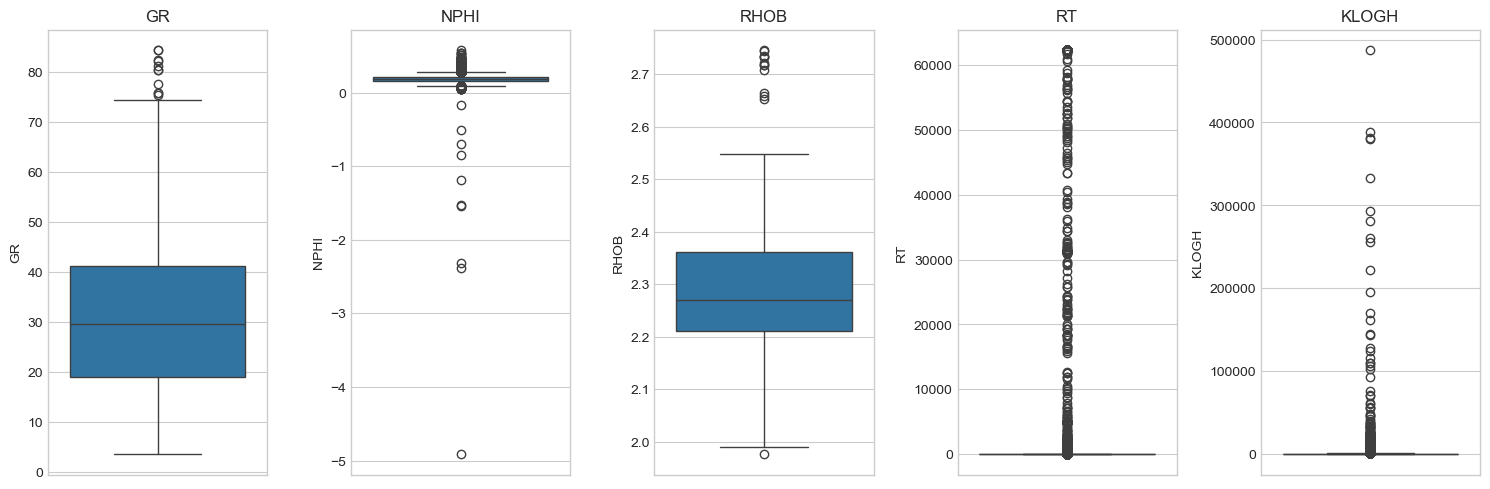

In [11]:
numeric_cols = ['GR', 'NPHI', 'RHOB', 'RT', 'KLOGH']
boxplot(df, numeric_cols)

In [12]:
df = outliers_detection(df, numeric_cols, 2)

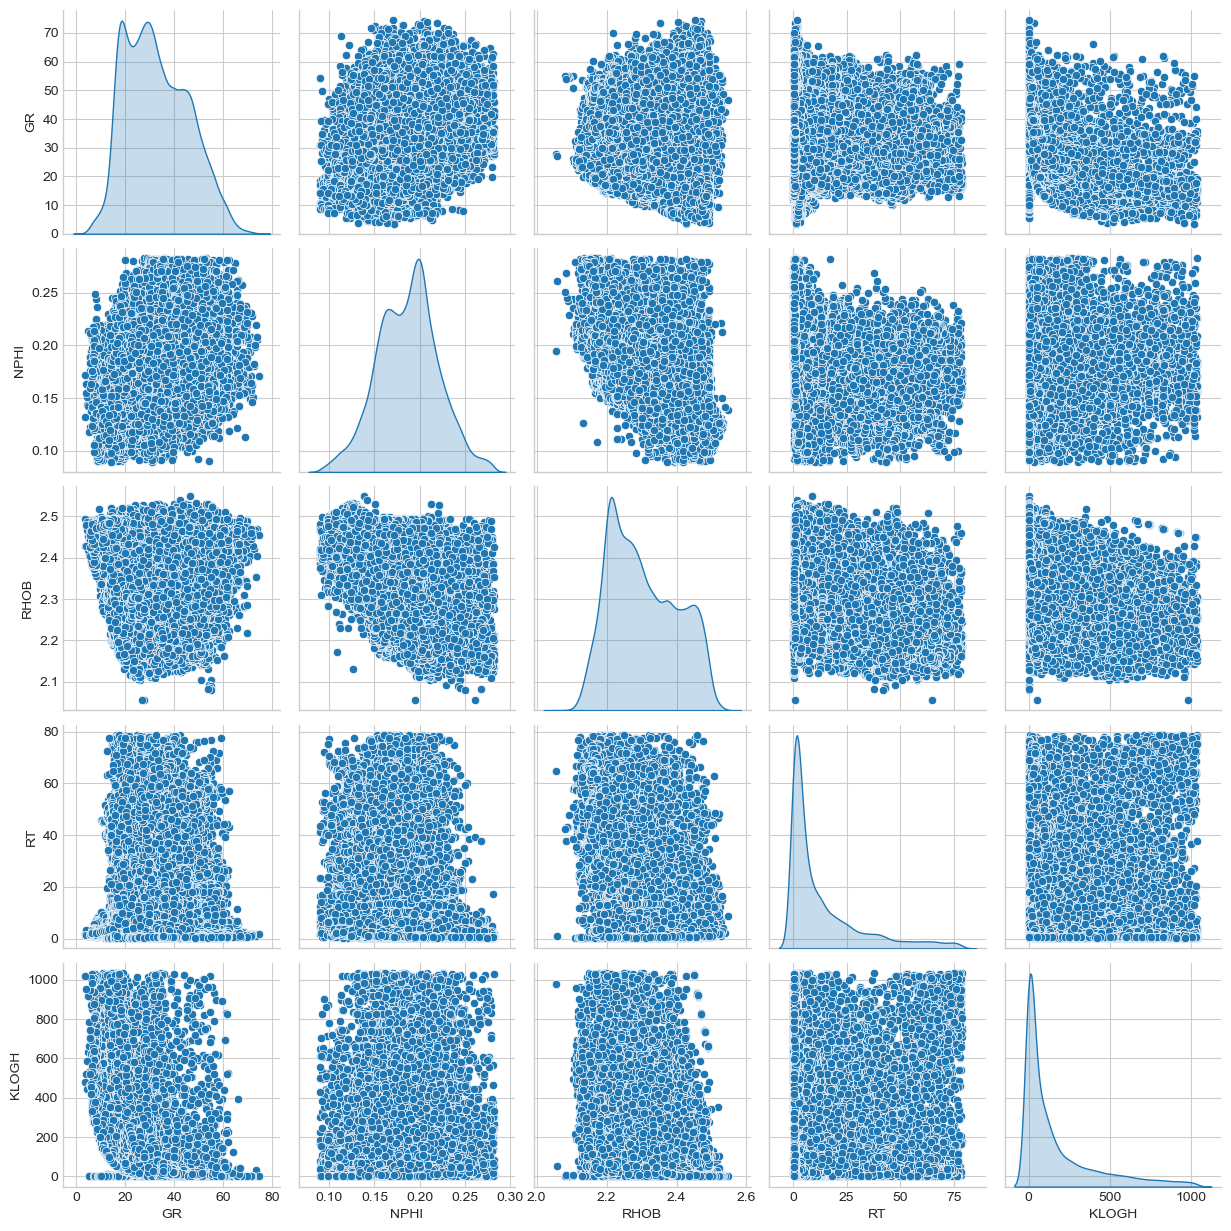

In [13]:
sns.pairplot(df[numeric_cols], diag_kind = 'kde')
plt.show()

In [14]:
scaled_data = MinMaxScaler().fit_transform(df[numeric_cols[:-1]])
df_scaled = pd.DataFrame(scaled_data, columns=numeric_cols[:-1], index=df.index)
df_scaled['KLOGH'] = df['KLOGH']

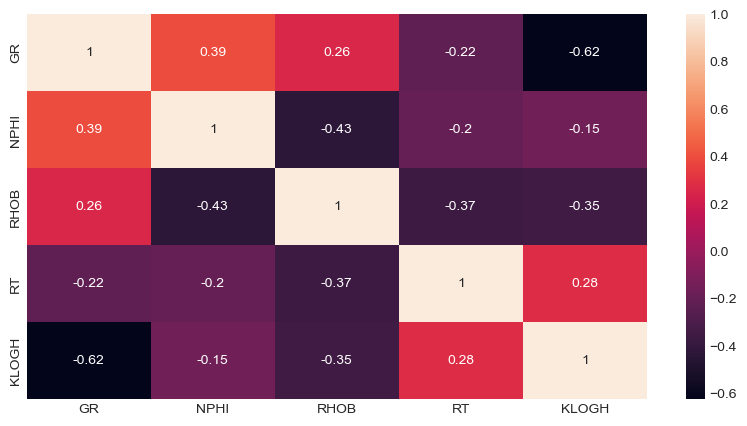

In [15]:
plt.figure(figsize=(10,5))
sns.heatmap(df_scaled[numeric_cols].corr(), annot=True)
plt.show()

In [16]:
features = df.drop(['KLOGH','SAND_FLAG', 'WELL'], axis=1)
target = df['KLOGH']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

In [17]:
features = df_scaled.drop('KLOGH', axis=1)
target = df_scaled['KLOGH']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

### Hyperparameters Tuning

In [18]:
# models = {
#     'Linear Regression': LinearRegression(),
#     'Ridge Regression': Ridge(random_state=RANDOM_STATE),
#     'Lasso Regression': Lasso(random_state=RANDOM_STATE),
#     'ElasticNet Regression': ElasticNet(random_state=RANDOM_STATE),
#     'Random Forest Regression': RandomForestRegressor(random_state=RANDOM_STATE),
#     'Support Vector Regression': SVR(),
#     'Decision Tree' : DecisionTreeRegressor(random_state=RANDOM_STATE),
#     'Gradient Boosting' : GradientBoostingRegressor(random_state=RANDOM_STATE),
#     'Multi-layer Perceptron' : MLPRegressor(random_state=RANDOM_STATE)
# }

In [19]:
# param_grids = {
#     'Ridge Regression': {
#         'alpha': [0.01, 0.1, 1, 10],
#         'tol': [1e-5, 1e-4, 1e-3, 1e-2],
#     },
#     'Lasso Regression': {
#         'alpha': [0.001, 0.01, 0.1, 1],
#         'tol': [1e-5, 1e-4, 1e-3, 1e-2],
#         'max_iter': [500, 1000, 2000]
#     },
#     'ElasticNet Regression': {
#         'alpha': [0.001, 0.01, 0.1, 1],
#         'l1_ratio': [0.1, 0.5, 0.9],
#         'tol': [1e-5, 1e-4, 1e-3, 1e-2],
#         'max_iter': [1000]
#     },
#     'Random Forest Regression': {
#         'n_estimators': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
#         'max_depth': list(range(2, 26, 2)),
#         'max_features': ['sqrt', 'log2', None] 
#     },
#     'Support Vector Regression': {
#         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#         'C': list(range(1, 10, 2)),
#         'gamma': ['scale', 'auto']
#     },
#     'Decision Tree' : {
#         'max_depth': [1, 2, 4, 8, 16, 32, 64, None],
#         'min_samples_split': [2, 5, 10, 20],
#         'min_samples_leaf': [1, 2, 4, 8]
#     },
#     'Gradient Boosting' : {
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#         'n_estimators': [50, 100, 200, 300],
#         'max_depth': [2, 3, 4, 5, 6]
#     },
#     'Multi-layer Perceptron' : {
#         'hidden_layer_sizes': [(50,), (100,), (100, 50)],
#         'activation': ['relu', 'tanh'],
#         'alpha': [0.0001, 0.001, 0.01],
#         'learning_rate_init': [0.001, 0.01],
#     } 
# }

In [20]:
# tuned_models = {}
# for name, model in models.items():
#     if name in param_grids:
#         grid = RandomizedSearchCV(model, param_grids[name], scoring='r2', cv=5, n_jobs=-1, random_state=RANDOM_STATE).fit(X_train, y_train)
#         best_model = grid.best_estimator_
#         best_params = grid.best_params_
#         best_score = grid.best_score_
#     else:
#         model.fit(X_train, y_train)
#         best_model = model
#         best_params = 'N/A'
        
#     tuned_models[name] = best_model

#     print(f'\n{name}')
#     print(f'Best Parameters: {best_params}')

In [21]:
tuned_models = {'Linear Regression': LinearRegression(),
                'Ridge Regression': Ridge(alpha=0.1, random_state=RANDOM_STATE, tol=0.01),
                'Lasso Regression': Lasso(alpha=0.001, max_iter=500, random_state=RANDOM_STATE, tol=0.001),
                'ElasticNet Regression': ElasticNet(alpha=0.001, l1_ratio=0.9, random_state=RANDOM_STATE, tol=1e-05),
                'Random Forest Regression': RandomForestRegressor(max_depth=18, max_features='sqrt', n_estimators=8,
                       random_state=RANDOM_STATE),
                'Support Vector Regression': SVR(C=1),
                'Decision Tree': DecisionTreeRegressor(max_depth=32, min_samples_leaf=8, min_samples_split=5,
                       random_state=RANDOM_STATE),
                'Gradient Boosting': GradientBoostingRegressor(learning_rate=0.2, max_depth=5, random_state=RANDOM_STATE),
                'Multi-layer Perceptron': MLPRegressor(hidden_layer_sizes=(100, 50), learning_rate_init=0.01,
                                         random_state=RANDOM_STATE)
              }

In [22]:
def evaluate_models(models, X_train, X_test, y_train, y_test):

    results = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save results
        results.append({
            'Model': name,
            'MSE': mse,
            'R²': r2
        })

        plt.figure(figsize=(6, 5))
        sns.scatterplot(x=y_test, y=y_pred)
        plt.xlabel('Actual Permeability, mD')
        plt.ylabel('Predicted Permeability, mD')
        plt.title(f'{name}\nMSE: {mse:.3f}   R²: {r2:.4f}')
        plt.savefig(name)
        plt.tight_layout()
        plt.show()
        
    return pd.DataFrame(results)

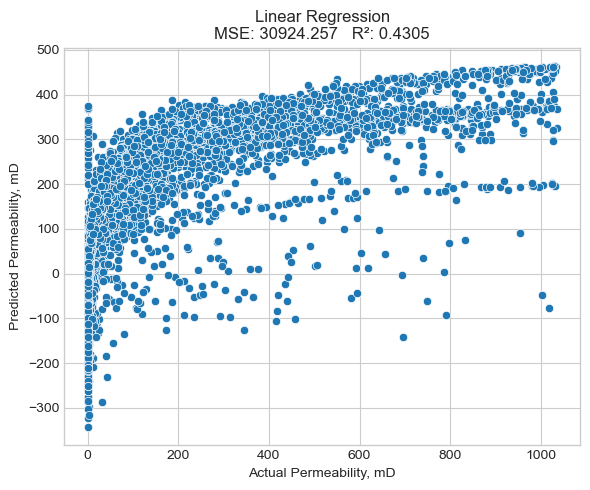

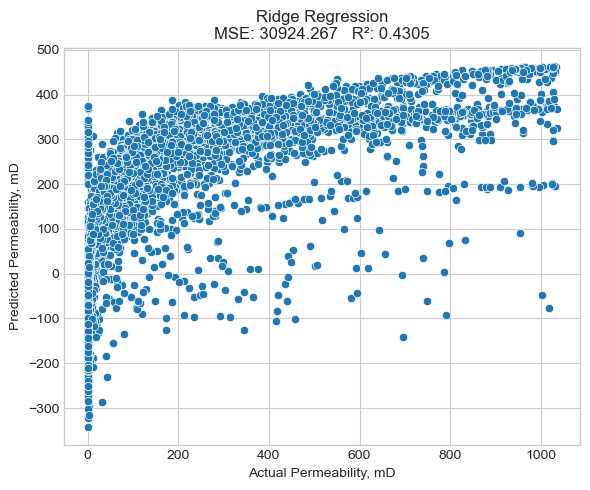

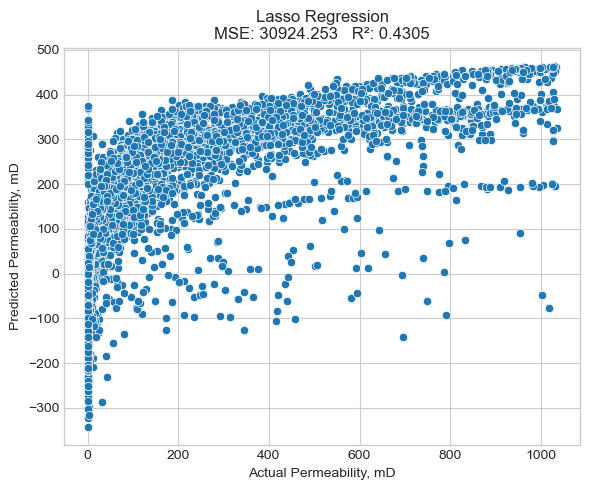

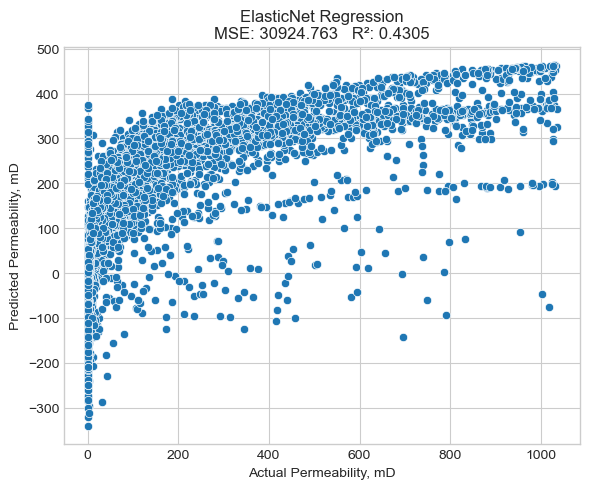

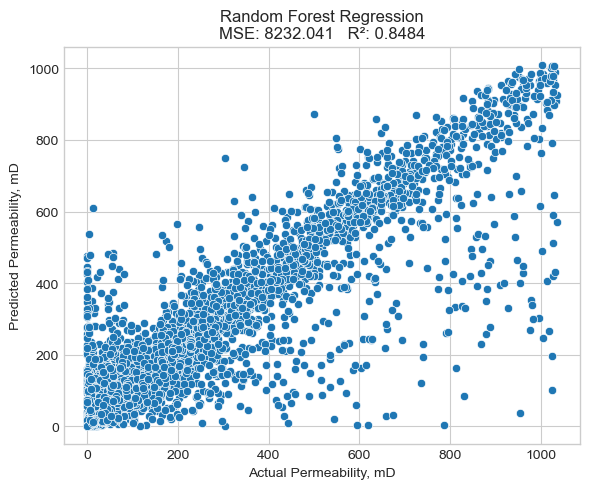

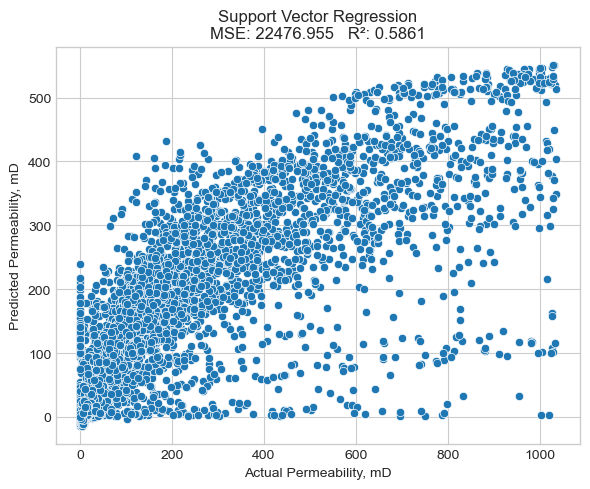

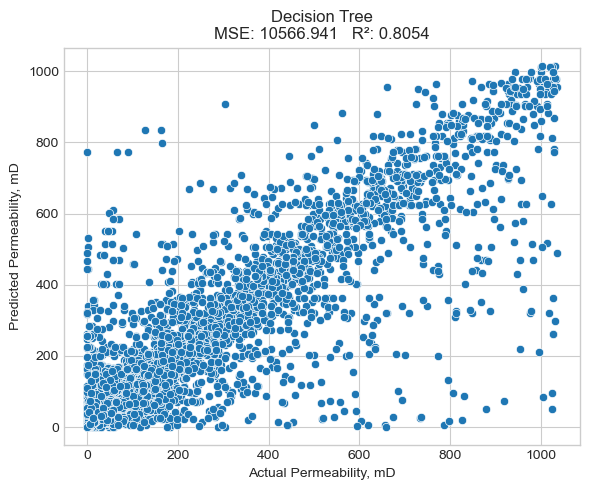

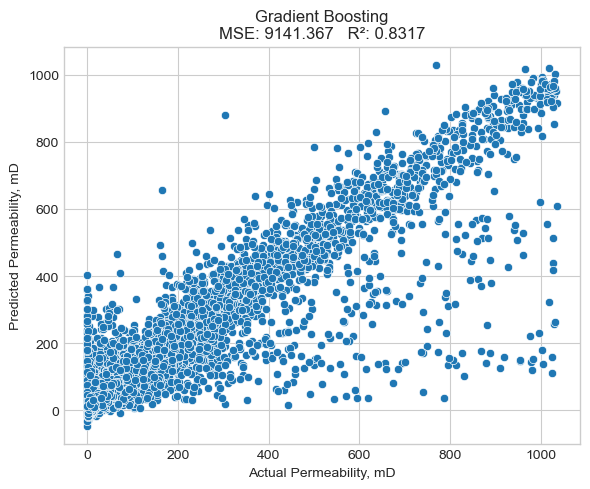

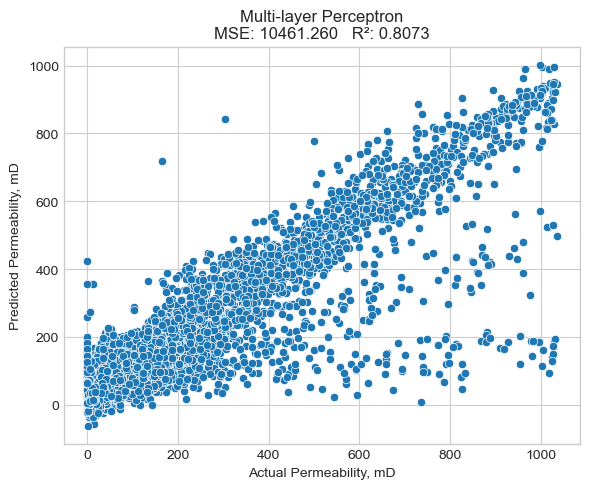

In [62]:
results = evaluate_models(tuned_models, X_train, X_test, y_train, y_test)

In [ ]:
results = results.sort_values(by=['R²'], ascending=False)
results.round(2)

### Additional Models

In [23]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import KNNImputer

In [24]:
# models = {
#     'KNeighborsRegressor': KNeighborsRegressor(),
#     'XGBRegressor': XGBRegressor(random_state=RANDOM_STATE),
#     'LGBMRegressor': LGBMRegressor(random_state=RANDOM_STATE)
# }

In [25]:
# param_grids = {
#     'KNeighborsRegressor': {
#         'n_neighbors': range (1, 50, 10)
#     },
#     'XGBRegressor': {
#           'max_depth': range (2, 10, 2),
#           'n_estimators': range(60, 220, 40),
#           'learning_rate': [0.1, 0.01, 0.05]
#     },
#     'LGBMRegressor': {
#         'max_depth': range (2, 10, 2),
#         'learning_rate': [0.1, 0.5, 0.8]
#     }
# }

In [26]:
# additional_models = {}
# for name, model in models.items():
#     if name in param_grids:
#         grid = RandomizedSearchCV(model, param_grids[name], scoring='r2', cv=5, n_jobs=-1, random_state=RANDOM_STATE).fit(X_train, y_train)
#         best_model = grid.best_estimator_
#         best_params = grid.best_params_
#         best_score = grid.best_score_
#     else:
#         model.fit(X_train, y_train)
#         best_model = model
#         best_params = 'N/A'
        
#     additional_models[name] = best_model

#     print(f'\n{name}')
#     print(f'Best Parameters: {best_params}')

In [27]:
additional_tuned_models = {
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=11),
    'XGBRegressor': XGBRegressor(n_estimators=70, max_depth=12, learning_rate=0.1, random_state=RANDOM_STATE),
    'LGBMRegressor': LGBMRegressor(max_depth=8, random_state=RANDOM_STATE)
}

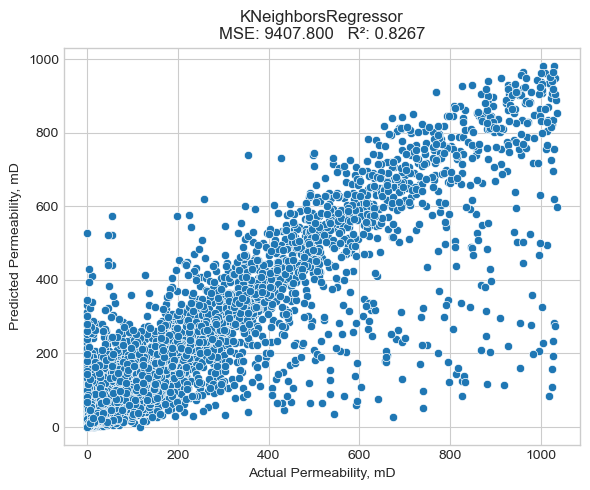

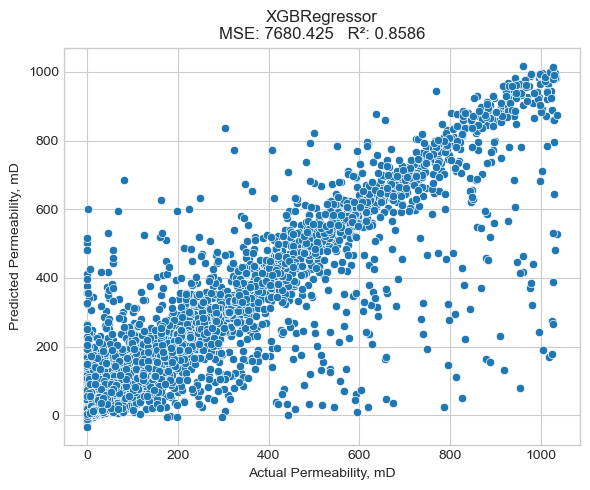

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 26901, number of used features: 4
[LightGBM] [Info] Start training from score 169.656907


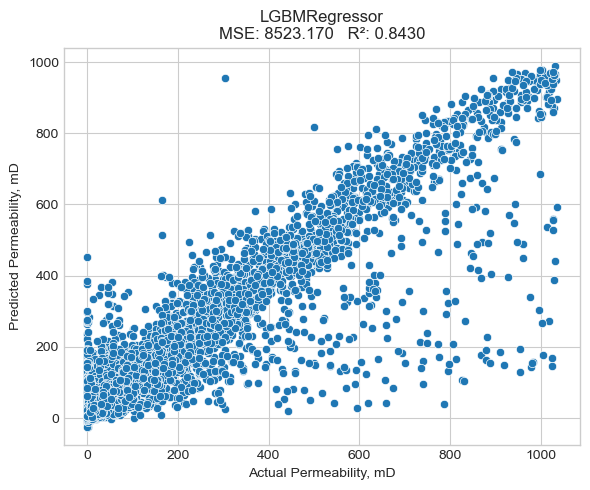

In [28]:
results_extra = evaluate_models(additional_tuned_models, X_train, X_test, y_train, y_test)

In [29]:
results_extra = results_extra.sort_values(by=['R²'], ascending=False)
results_extra.round(2)

,Model,MSE,R²
1,XGBRegressor,7680.42,0.86
2,LGBMRegressor,8523.17,0.84
0,KNeighborsRegressor,9407.80,0.83


### Features Importance

In [30]:
model_xgb = XGBRegressor(n_estimators=70, max_depth=12, learning_rate=0.1, random_state=RANDOM_STATE)
model_rf = RandomForestRegressor(max_depth=18, max_features='sqrt', n_estimators=8,
                       random_state=RANDOM_STATE)

model_xgb.fit(X_train, y_train)
model_rf.fit(X_train, y_train);

In [31]:
importances_xgb = model_xgb.feature_importances_
importances_rf = model_rf.feature_importances_

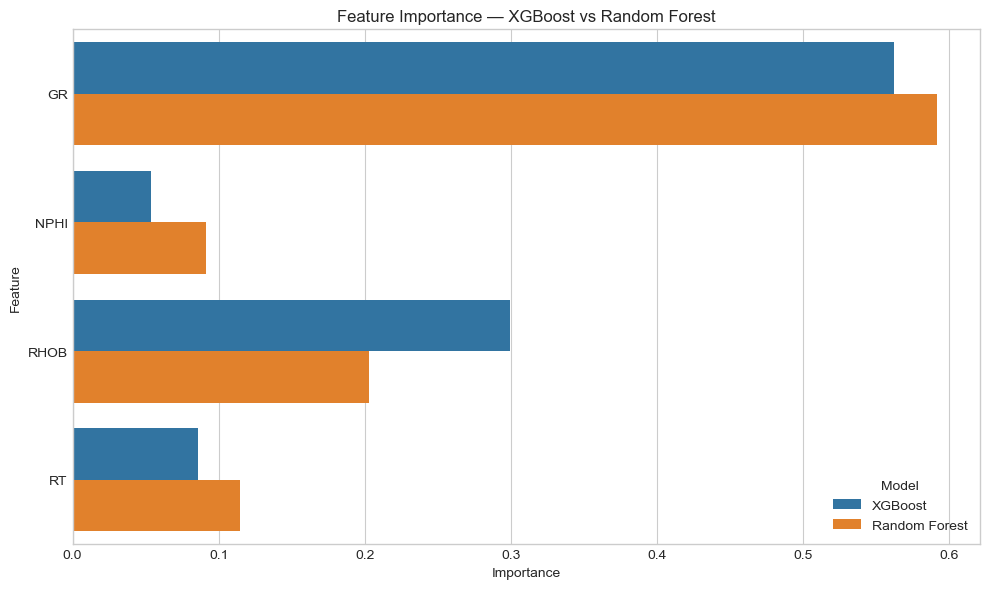

In [32]:
features = ['GR', 'NPHI', 'RHOB', 'RT']

df = pd.DataFrame({
    'Feature': features * 2,
    'Importance': importances_xgb.tolist() + importances_rf.tolist(),
    'Model': ['XGBoost'] * len(features) + ['Random Forest'] * len(features)
})

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Importance', y='Feature', hue='Model')
plt.title("Feature Importance — XGBoost vs Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()

plt.savefig('feature_importance')
plt.show()


### Dealing with NaN

In [88]:
combined_dfs_las = []
for i, j in zip(input_las_file_list, output_las_file_list):
    try:
        las_input = lasio.read(i)  
        df_input = las_input.df()[['GR','NPHI','RHOB', 'RT']]
        las_output = lasio.read(j).df()[['KLOGH','SAND_FLAG' ]]
        combined_df = pd.merge(df_input,las_output, on = 'DEPTH')
        combined_df['WELL'] = las_input.well.WELL.value
        combined_dfs_las.append(combined_df)
    except:
        pass

df_las = pd.concat(combined_dfs_las)

combined_dfs_dlis = []
for i, j in zip(input_dlis_file_list, output_dlis_file_list):
    f_inp, *_ = dlis.load(i)
    f_out, *_ = dlis.load(j)
    
    origin = f_inp.origins[0]
    well_name = origin.well_name    
    
    for m, n  in zip(f_inp.frames, f_out.frames): 
        dlis_input = m.curves()[['DEPTH','GR','NPHI','RHOB', 'RT']]
        dlis_output = n.curves()[['DEPTH','KLOGH', 'SAND_FLAG']]
                
        curves_inp = pd.DataFrame(dlis_input)
        curves_out =  pd.DataFrame(dlis_output)

        curves_inp['DEPTH'] = curves_inp['DEPTH'] * 0.00254
        curves_out['DEPTH'] = curves_out['DEPTH'] * 0.00254
        
        curves_inp.set_index('DEPTH', inplace=True)
        curves_out.set_index('DEPTH', inplace=True)

        combined_df = pd.concat([curves_inp, curves_out], axis=1)
        combined_df['WELL'] = well_name
        combined_dfs_dlis.append(combined_df)

df_dlis = pd.concat(combined_dfs_dlis)

df = pd.concat([df_las, df_dlis])

In [89]:
df = df.drop('WELL', axis=1)

In [90]:
df = df[df['SAND_FLAG'] > 0]

In [91]:
values_to_drop = [-999.25]
df = df[~df['KLOGH'].isin(values_to_drop)]
df = df[~df['SAND_FLAG'].isin(values_to_drop)]
df = df.dropna(subset=['SAND_FLAG', 'KLOGH'])

In [92]:
imputer = KNNImputer(weights="distance")
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

In [93]:
df = df_imputed

In [94]:
df = df.dropna()

In [95]:
df = outliers_detection(df, numeric_cols, 2)

In [96]:
scaled_data = MinMaxScaler().fit_transform(df[numeric_cols[:-1]])
df_scaled = pd.DataFrame(scaled_data, columns=numeric_cols[:-1], index=df.index)
df_scaled['KLOGH'] = df['KLOGH']

In [97]:
features = df_scaled.drop('KLOGH', axis=1)
target = df_scaled['KLOGH']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE)

In [98]:
models = {
    'XGBRegressor': XGBRegressor(n_estimators=70, max_depth=12, learning_rate=0.1, random_state=RANDOM_STATE),
    'Random Forest Regression': RandomForestRegressor(max_depth=18, max_features='sqrt', n_estimators=8,
                       random_state=RANDOM_STATE)
}

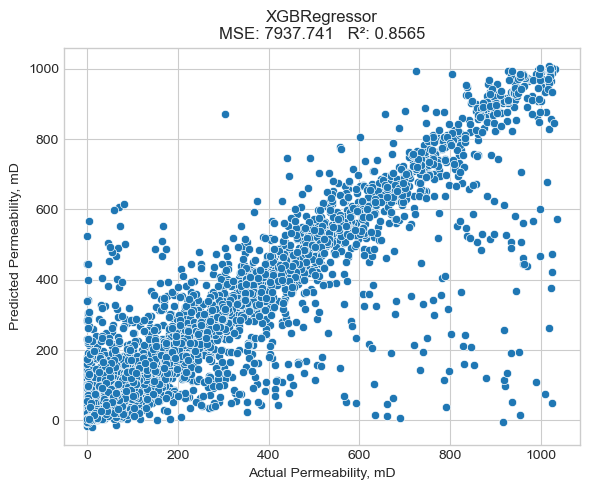

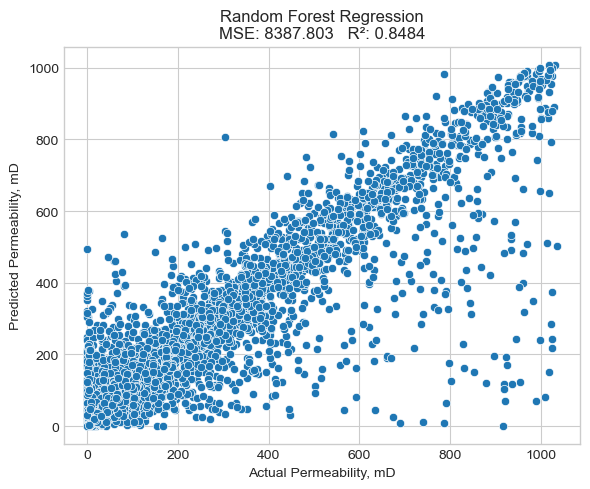

In [99]:
results_extra = evaluate_models(models, X_train, X_test, y_train, y_test)